In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

from collections import Counter

from tqdm.notebook import tqdm

## Scrapping Web page

Method `scrap_page(url)` scraps category, title, content and urls from a given page. This method is tailored for `slobodnadalmacija.hr` and other urls cound have category, title, content and/or urls in different HTML tags.

In [94]:
ROOT_URL = "https://slobodnadalmacija.hr"

def scrap_page(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content)

    data = {"url": url,
            "category": "", 
            "title": "",
            "content": "",
            "urls": set()}
    
    # kategorija
    category = url.split("/")[3:4]
    data["category"] = "".join(category)

    # scrap title
    h1 = soup.find("h1")
    if h1:
        data["title"] = h1.text.strip()

    # scrap content
    text = []
    div = soup.find("div", class_="itemFullText")
    if div:
        for p in div.find_all("p"):
            text.append(p.text.strip())
        data["content"] = "\n".join(text)

    # scrap urls
    for a in soup.find_all("a", class_="card__article-link"):
        if a["href"].startswith("http"):
            data["urls"].add(a["href"])
        else:
            data["urls"].add(ROOT_URL + a["href"])

    return data
    
root_data = scrap_page(ROOT_URL)
#root_data

# Scrapping multiple pages

This method scraps multiple pages starting from the root page and follows internal hyperlinks and scraps those pages too.

In [95]:
def scrap_multiple_pages(root_url):
    dataset = []
    visited_urls = {root_url}

    root_data = scrap_page(root_url)

    prev_urls = root_data["urls"]
    next_urls = set()
    for url in tqdm(prev_urls):
        data = scrap_page(url)
        dataset.append(data)
        next_urls.update(data["urls"])
    next_urls -= visited_urls

    return dataset

dataset = scrap_multiple_pages(ROOT_URL)


  0%|          | 0/126 [00:00<?, ?it/s]

## Presenting data as dataframe

Don't forget to save the data!

In [96]:
scrap_df = pd.DataFrame(dataset).drop("urls", axis=1)
scrap_df

,url,category,title,content
0,https://slobodnadalmacija.hr/mozaik/zdravlje/o...,mozaik,Ovo je najbolji protuupalni napitak za poboljš...,Zamršena veza između imuniteta i gubitka težin...
1,https://slobodnadalmacija.hr/vijesti/svijet/vu...,vijesti,"Vučić šeta Srbijom, dijeli po 85 eura srednjoš...",Smiju li hrvatski mediji uopće pratiti predizb...
2,https://slobodnadalmacija.hr/vijesti/politika/...,vijesti,Vanđelić o mogućim koalicijama: ‘Kćer mi je re...,"Damir Vanđelić, novi predsjednik nove stranke ..."
3,https://slobodnadalmacija.hr/zadar/regional/ba...,zadar,Barbarićeva kuća mora pasti! Upravni sud dao ‘...,"Frane Barbarić, predsjednik uprave HEP-a i pot..."
4,https://slobodnadalmacija.hr/vijesti/hrvatska/...,vijesti,Jeste li i vi zapazili vozni park kojim slavon...,Seljaci danima prosvjeduju po Slavoniji.\nBlok...
...,...,...,...,...
121,https://slobodnadalmacija.hr/mozaik/panorama/t...,mozaik,Tjedni horoskop: Ovnovima intimni život donosi...,OVAN\n21. OŽUJKA – 20. TRAVNJA\nNa poslu ćete ...
122,https://slobodnadalmacija.hr/vijesti/hrvatska/...,vijesti,"Frane Barbarić: ‘Sam ću srušiti vilu na Hvaru,...","Općinski sud u Splitu, kako doznaje Jutarnji l..."
123,https://slobodnadalmacija.hr/dalmacija/zagora/...,dalmacija,Legendarna dalmatinska škola dobit će potpuno ...,"Do kraja lipnja 2026. godine, Vrgorska krajina..."
124,https://slobodnadalmacija.hr/sport/strani-nogo...,sport,"Stipe Biuk i Los Angeles izborili finale, na p...","Nogometaši Los Angeles FC-a, za koji igra Stip..."


Number of documents per category

In [97]:
scrap_df.category.value_counts()

dalmacija    26
mozaik       19
vijesti      17
split        15
sport        14
scena        11
dubrovnik     7
spiza         5
kultura       5
zadar         3
om            2
sibenik       2
Name: category, dtype: int64

## Functions for splitting sentences and tokens

Sentence splitting in this case uses regular expression for finding interpuction character following by whitespace and replacing them with a new line. Then splits given string by new line.

Token splittining in this case uses regular expression for finding all sequences of alphanumerical characters and sequences of special non alphanumeric characters.

In [98]:
import re

def split_sents(txt):
    txt = re.sub(r"([.?!])\s+", r"\1\n", txt)
    return txt.split("\n")

def split_tokens(txt):
    return re.findall(r"\w+|[.!?;:,.\"\'\(\)\[\]\{\}]+", txt)


sents = split_sents(dataset[0]["content"])
sent = sents[1]
print(sent)
tokens = split_tokens(sent)
print(tokens)


Protuupalni napici, bogati antioksidansima, pojavili su se kao moćni saveznici u podršci imunitetu i kontroli tjelesne težine.
['Protuupalni', 'napici', ',', 'bogati', 'antioksidansima', ',', 'pojavili', 'su', 'se', 'kao', 'moćni', 'saveznici', 'u', 'podršci', 'imunitetu', 'i', 'kontroli', 'tjelesne', 'težine', '.']


## Collecting all tokens from scrapped Web pages

In [99]:
def get_token_freqs(df):
    tokens = Counter()
    for txt in df.content:
        for sent in split_sents(txt.lower()):
            tokens.update(split_tokens(sent))
    return tokens

all_tokens = get_token_freqs(scrap_df)
            


all_tokens.most_common(20)

[(',', 3376),
 ('.', 2454),
 ('i', 1937),
 ('je', 1755),
 ('u', 1506),
 ('na', 896),
 ('se', 818),
 ('za', 636),
 ('da', 625),
 ('su', 506),
 ('a', 479),
 ('"', 376),
 ('od', 352),
 ('s', 349),
 ('će', 295),
 ('koji', 279),
 ('kako', 255),
 ('to', 230),
 ('ne', 229),
 ('što', 217)]

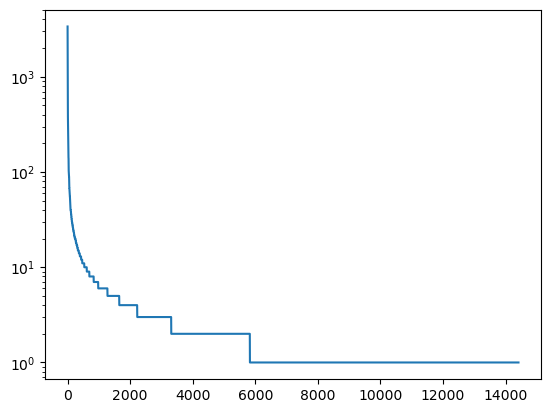

In [100]:
import matplotlib.pyplot as plt

freqs = [f for _, f in all_tokens.most_common()]

plt.yscale("log")
plt.plot(sorted(all_tokens.values(), reverse=True))

# Some descriptive statistics

<AxesSubplot: title={'center': 'Number of documents per class'}>

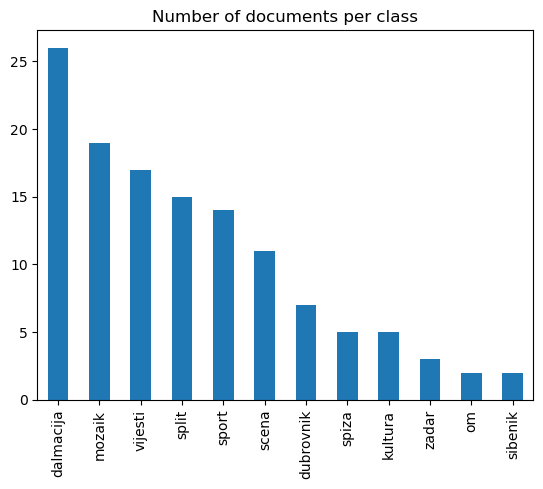

In [101]:
scrap_df.category.value_counts().plot.bar(title="Number of documents per class")

In [107]:
items = {"category": [],
         "docs": [],
        "sents": [],
        "tokens": [],
        "unique_tokens": []}

for category, txt in zip(scrap_df.category, df.content):
    items["category"].append(category)
    items["docs"].append(1)
    
    sents = split_sents(txt)
    items["sents"].append(len(sents))

    doc_tokens = []
    for sent in sents:
        doc_tokens += split_tokens(sent)
    items["tokens"].append(len(doc_tokens))
    items["unique_tokens"].append(len(set(doc_tokens)))

category_df = pd.DataFrame(items)

#item_df.groupby("category").sum()
category_df = category_df.groupby("category").sum()
category_df


    


    

,docs,sents,tokens,unique_tokens
category,,,,
dalmacija,26,769,15475,7422
dubrovnik,7,203,4116,2270
kultura,5,59,1737,1093
mozaik,19,652,10126,5365
om,2,29,901,554
scena,11,243,4475,2549
sibenik,2,17,349,233
spiza,5,118,2496,1529
split,15,244,4548,2920


<AxesSubplot: title={'center': 'Number of docs, sents, tokens and unique tokens per category'}, xlabel='category'>

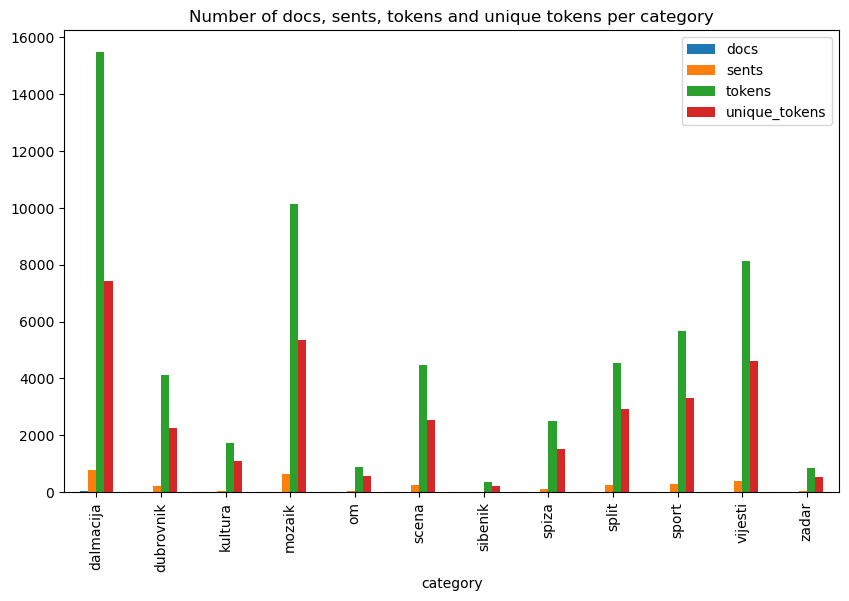

In [112]:
category_df.plot.bar(figsize=(10, 6), title="Number of docs, sents, tokens and unique tokens per category")